In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from google.colab import drive

In [83]:
plt.style.use("ggplot")

In [84]:
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [85]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [86]:
# train = pd.read_csv("drive/data/raw/train.csv")
# test = pd.read_csv("data/raw/test.csv")

train = pd.read_csv("/content/drive/MyDrive/mnist/train.csv")
test = pd.read_csv("/content/drive/MyDrive/mnist/test.csv")

In [87]:
X_train = train.drop(columns="label").values
y_train = train["label"].values

In [88]:
X_test = test.values

In [89]:
# Normalize the data
X_train = X_train / 255
X_test = X_test / 255

In [90]:
# Reshape to image format
X_train = X_train.reshape(-1, 1, 28, 28)
X_test = X_test.reshape(-1, 1, 28, 28)

In [91]:
# One hot encoding
y_train_oh = torch.eye(10)[y_train]

In [92]:
# Convert X, y to tensor
X_train = torch.Tensor(X_train)
y_train_oh = torch.Tensor(y_train_oh)

X_test = torch.Tensor(X_test)

In [93]:
class CNN(nn.Module):
    def __init__(self,
                 num_filters1=8,
                 num_filters2=16,
                 num_hidden_units=256):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(1, num_filters1, kernel_size=5, padding=2)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(0.25)

        self.conv2 = nn.Conv2d(num_filters1, num_filters2,
                               kernel_size=3,padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout2 = nn.Dropout(0.25)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(num_filters2 * 7 * 7, num_hidden_units)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(num_hidden_units, 10)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.dropout1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.dropout2(x)

        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.dropout3(x)
        x = self.fc2(x)
        x = self.softmax(x)

        return x

In [94]:
num_samples = X_train.shape[0]

In [102]:
num_filters1 = 8
num_filters2 = 16
num_hidden_units=256
learning_rate = 0.001
num_epochs = 200
batch_size = 500

model = CNN(num_filters1=num_filters1, num_filters2=num_filters2,
            num_hidden_units=num_hidden_units)

# Move the model, input data, and labels to the GPU
model = model.to(device)
X_train = X_train.to(device)
y_train_oh = y_train_oh.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    for start_index in range(0, num_samples, batch_size):
        end_index = start_index + batch_size
        if end_index > num_samples: continue
        X_batch = X_train[start_index: end_index]
        y_batch = y_train_oh[start_index: end_index]

        # Forward pass
        y_batch_ = model(X_batch)
        loss = criterion(y_batch_, y_batch)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [103]:
y_train_oh_ = model(X_train)
y_train_ = torch.argmax(y_train_oh_, dim=1).cpu().numpy()

accuracy = accuracy_score(y_train, y_train_)

print(f"Training accuracy: {accuracy}")

Training accuracy: 0.9894761904761905


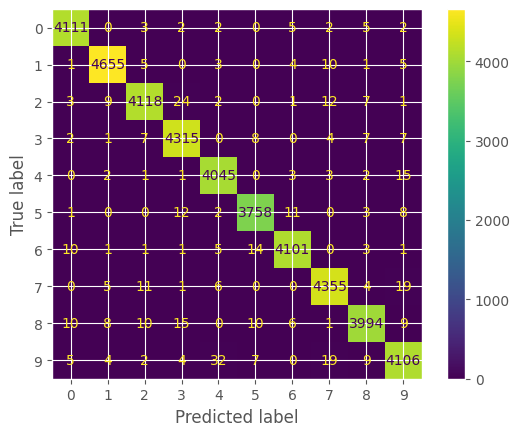

In [104]:
disp = ConfusionMatrixDisplay(confusion_matrix(y_train, y_train_))
disp.plot()

In [105]:
# Move X_test to GPU
X_test = X_test.to(device)

# Make predictions from X_test
y_test_oh_ = model(X_test)
y_test_ = torch.argmax(y_test_oh_, dim=1).cpu().numpy()

In [106]:
test_predictions = pd.Series(y_test_, name="Label")
test_predictions.index.name = "ImageId"
test_predictions.index += 1 # kaggle expects one indexed predictions

In [107]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [108]:
test_predictions.to_csv("/content/drive/MyDrive/mnist/cnn_baseline.csv")

Submitted to kaggle and got an accuracy of 0.9805